# EU-28 Quality of Life prediction using Deep Learning

## SHORT INTRO, DATA AND METHODS

As a natural extension of my DataCamp Data Science training, I decided to create a Deep Learning Machine
Learning model of my thesis research (see my LinkedIn “Publications” section for the full text), to see if similar
results may be obtained using Deep Learning methods (Keras/TensorFlow) applied to the same data. I am still a
relative Python novice, so please bear with me.

First, a brief introduction to the original study including results is presented, then the Deep Learning model result
and a comparison of the two, followed by the Python program code for the Deep Learning model itself.

The original study presents a model to quantitatively estimate the spatial well-being (QoL) distribution across the
EU-28 member states down to the municipal level, using tools offered by GIS. The model is weight-driven and
based on Eurostat statistics on objective key QoL indicators, identified by the 2016 Eurostat Analytical report on
subjective well-being and the 2013 EU-SILC ad-hoc module on well-being. Additionally, some Europe 2020
strategy targets of the European Commission, deemed to be important to a sense of personal well-being, are
included, such as the risk of poverty or social exclusion and advanced educational attainment.

A climatic comfort component based on 1961-1990 climatic normals is added to estimate the importance of (a
static) climate to QoL. Thermal comfort levels are obtained using the Universal Thermal Climate Index (UTCI)
and Predicted Mean Vote (PMV), and overall climatic comfort levels are obtained as a weighted linear
combination based on the classical Tourism Climatic Index (TCI).

To evaluate the performance of the model, individual mean country results for year 2014 are compared to actual
country results of the 2013 EU and 2014 OECD subjective well-being surveys. The modeled spatial QoL
distribution is also forecast into year 2020, using simple linear regression of the selected socioeconomic factors.

The findings suggest that the model is able to estimate actual well-being levels from quantitative country statistics.
Even closer agreement should be possible with careful calibration of the model weights to the prevailing attitudes
and priorities of each individual region/member country and using more sophisticated regression methods for
forecasting. The findings also suggest that subjective well-being components could be isolated from the objective
model baselines. Furthermore, a (static) climate seems to play a less important, and perhaps even negative, role
than we might think, compared to most of the selected socioeconomic factors.

The 12 model well-being indicators, with their respective abbreviations: 


Indicator                                                                                  Abbreviation

Healthy Life Years at birth as a percentage of life expectancy	                           HEALTH 
Severe material deprivation	                                                               POV 
Employment (total), ages 20-64	                                                           EMPL 
Crimes recorded (aggregate)	                                                               CRIME 
People at risk of poverty or social exclusion	                                           MTRL 
Real adjusted gross disposable income of households per capita	                           DISP_INC 
Tertiary educ. attainment (total), ages 30-34	                                           EDUC 
Comparative price levels of final consumption by private households incl. indirect taxes   PR_LVLS 
Climatic comfort 	                                                                       TCI 
Gini coefficient of equivalised disposable income	                                       INC_EQ 
Early leavers from education/ training (total), ages 18-24	                               LEAVERS 
Gender equality (overall earnings gap)	                                                   GENDER 



ORIGINAL THESIS MODEL RESULTS (MANUAL WEIGHTING)

The figure below shows modeled objective well-being levels (0-10 Cantril ladder scale), including a calculated climatic comfort factor, for the 28 EU member states (except Cyprus) for year 2014 (a) and projected into year 2020 (b), using simple linear regression. Also shown is a regression analysis between the model results (“2014 MCE country mean”) and the 2013 EU-SILC and 2014 OECD subjective well-being surveys, as well as individual 2014 model indicator/EU-SILC correlations.


![2014.jpg](images/2014.jpg)

![2020.jpg](images/2020.jpg)

![graph.jpg](images/graph.jpg)


PYTHON PROGRAM CODE:


In [132]:
"""
Deep Learning Keras/TensorFlow regression model of EU-28 Quality of Life (QoL) levels for year 2014,
using 11 socioeconomic indicators, retrieved from Eurostat, as predictors and 1 climatic comfort predictor.
The target is 2013 EUSILC QoL survey data (ground truth).

There are *no* missing data points in this set and it already includes column headers.

The total number of datapoints in this set (csv file) is 15473.
"""

# Import the necessary modules.
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Import the raw data as pandas dataframe "df" and print out the first few raw observations, together with the Pandas info.

In [133]:
df = pd.read_csv('merged_raw_data_2014.csv', delimiter=',')
print(df.head())
print(df.info())

   OBJECTID  POINTID        LAT        LON NUTS_ID  STAT_LEVL_ CNTR_CODE  \
0         1        1  70.123594  27.706466   FI1D7         3.0        FI   
1         2        2  70.083933  28.120080   FI1D7         3.0        FI   
2         3        3  70.003202  27.192305   FI1D7         3.0        FI   
3         4        4  69.964716  27.604875   FI1D7         3.0        FI   
4         5        5  69.925355  28.016308   FI1D7         3.0        FI   

    CRIME  DISP_INC  LEAVERS   ...    GENDER  HEALTH  INC_EQ  MTRL   POV  \
0  0.0083   23153.0      7.9   ...      24.5   71.65    25.6   2.4  21.6   
1  0.0083   23153.0      7.9   ...      24.5   71.65    25.6   2.4  21.6   
2  0.0083   23153.0      7.9   ...      24.5   71.65    25.6   2.4  21.6   
3  0.0083   23153.0      7.9   ...      24.5   71.65    25.6   2.4  21.6   
4  0.0083   23153.0      7.9   ...      24.5   71.65    25.6   2.4  21.6   

   PR_LVLS       TCI    WS_QoL  WS_QoLadj  EUSILC  
0    122.3  0.249433  0.609759   6

Define the Pearson r correlation coefficient function.

In [134]:
def pearson_r(array1, array2):
    """
    Compute Pearson correlation coefficient between two arrays.
    """
    corr_mat = np.corrcoef(array1, array2)
    # Return entry [0,1]
    return corr_mat[0, 1]

Instantiate a scaler to normalize  (mean of 0, variance of 1) the features.

Create and scale the target and predictor arrays (dropping unwanted columns in the dataframe).
Print out the number of predictors (12 features/indicators), as a check.

Create additional variables for convenience.

In [135]:
scaler = StandardScaler()

# Create and reshape the target matrix (due to a Python deprecation warning in 0.17, resulting in a ValueError in 0.19).
target = df.EUSILC.as_matrix().reshape(-1, 1)

target_scaled = scaler.fit_transform(target)

predictors = df.drop([
        'EUSILC', 'WS_QoL', 'WS_QoLadj','CNTR_CODE', 'OBJECTID', 'POINTID', 'NUTS_ID', 'STAT_LEVL_', 'LAT', 'LON'
                    ], axis=1).as_matrix()

predictors_scaled = scaler.fit_transform(predictors)

# Number of model input features (columns):
n_cols = predictors_scaled.shape[1]
print('Number of input features (columns): ', n_cols)

# Number of neurons in the input layer:
input_neurons = 100

# Number of hidden layers:
hidden_layers = 5

# Number of neurons in the hidden layers:
hidden_neurons = 10

# Number of neurons in the output layer:
output_neurons = 1

# Activation function:
activation_function = 'relu'

# Optimizer:
optimizer = 'adam'

# Loss function:
loss_function = 'mean_squared_error'

# Early stopping value:
early_stopping_patience = 3

# Batch size:
batch_size = 25

# Max number of epochs:
epochs = 50

Number of input features (columns):  12


Create the model and add the input and hidden layers iteratively.
Optionally, Dropout could be used (to prevent over-fitting) in between the layers, like:

model = Sequential()

model.add(Dense(500, activation='relu', input_shape=(n_cols,)))

model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(1))


In [136]:
model = Sequential()

# 100 neurons initially, then 10 in each hidden layer
model.add(Dense(input_neurons, activation=activation_function, input_shape=(n_cols,)))

for i in range(1, hidden_layers):
    model.add(Dense(hidden_neurons, activation=activation_function))
    # model.add(Dropout(0.2))

Add final output layer (one neuron).

Check out the final model topology by running a summary:

In [137]:
model.add(Dense(output_neurons))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 100)               1300      
_________________________________________________________________
dense_57 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_58 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_59 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_60 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 11        
Total params: 2,651.0
Trainable params: 2,651
Non-trainable params: 0.0
_________________________________________________________________


Compile the model, with mean squared error loss function as a measure of model success.

Provide early stopping if no improvements are shown.

In [138]:
model.compile(optimizer=optimizer, loss=loss_function)
early_stopping_monitor = EarlyStopping(patience=early_stopping_patience)

Fit the model, splitting into training and hold-out sets (70/30).

Print out the minimum validation loss achieved.

In [139]:
history = model.fit(predictors_scaled,
                    target_scaled,
                    batch_size=batch_size,
                    validation_split=0.3,
                    epochs=epochs,
                    callbacks=[early_stopping_monitor],
                    verbose=2)

print("\nMin. validation loss: ", np.min(history.history['val_loss']))

Train on 10831 samples, validate on 4642 samples
Epoch 1/50
0s - loss: 0.0954 - val_loss: 0.7268
Epoch 2/50
0s - loss: 0.0045 - val_loss: 0.8130
Epoch 3/50
0s - loss: 0.0031 - val_loss: 0.7458
Epoch 4/50
0s - loss: 0.0022 - val_loss: 0.7141
Epoch 5/50
0s - loss: 0.0019 - val_loss: 0.6938
Epoch 6/50
0s - loss: 0.0016 - val_loss: 0.5972
Epoch 7/50
0s - loss: 0.0013 - val_loss: 0.5158
Epoch 8/50
0s - loss: 0.0013 - val_loss: 0.4704
Epoch 9/50
0s - loss: 9.5768e-04 - val_loss: 0.4491
Epoch 10/50
0s - loss: 0.0010 - val_loss: 0.4583
Epoch 11/50
0s - loss: 9.1949e-04 - val_loss: 0.4147
Epoch 12/50
0s - loss: 5.5994e-04 - val_loss: 0.4011
Epoch 13/50
0s - loss: 5.4042e-04 - val_loss: 0.3978
Epoch 14/50
0s - loss: 5.8711e-04 - val_loss: 0.3949
Epoch 15/50
0s - loss: 9.1965e-04 - val_loss: 0.3559
Epoch 16/50
0s - loss: 4.9593e-04 - val_loss: 0.3692
Epoch 17/50
0s - loss: 5.3804e-04 - val_loss: 0.3674
Epoch 18/50
0s - loss: 3.2117e-04 - val_loss: 0.3724
Epoch 19/50
0s - loss: 1.6068e-04 - val_lo

MODEL PREDICTING:

Calculate predictions and flatten the array. The predictions will be probabilities.

Shift the predictions up by the difference in means to the standard 0-10 scale of the EU-SILC survey data.

In [140]:
predictions = model.predict(predictors_scaled)
predictions_flat = predictions.ravel()

predictions_scaled = predictions_flat - np.mean(predictions_flat) + np.mean(target)

Create combined dataframe and print the result.

In [141]:
probs = [('POINTID', df['POINTID']), ('QoL_pred_prob', list(predictions_scaled))]
df_predicted = pd.DataFrame.from_items(probs)
df_combined = pd.merge(df, df_predicted, how='left', on='POINTID')

print(df_combined.head())

   OBJECTID  POINTID        LAT        LON NUTS_ID  STAT_LEVL_ CNTR_CODE  \
0         1        1  70.123594  27.706466   FI1D7         3.0        FI   
1         2        2  70.083933  28.120080   FI1D7         3.0        FI   
2         3        3  70.003202  27.192305   FI1D7         3.0        FI   
3         4        4  69.964716  27.604875   FI1D7         3.0        FI   
4         5        5  69.925355  28.016308   FI1D7         3.0        FI   

    CRIME  DISP_INC  LEAVERS      ...        HEALTH  INC_EQ  MTRL   POV  \
0  0.0083   23153.0      7.9      ...         71.65    25.6   2.4  21.6   
1  0.0083   23153.0      7.9      ...         71.65    25.6   2.4  21.6   
2  0.0083   23153.0      7.9      ...         71.65    25.6   2.4  21.6   
3  0.0083   23153.0      7.9      ...         71.65    25.6   2.4  21.6   
4  0.0083   23153.0      7.9      ...         71.65    25.6   2.4  21.6   

   PR_LVLS       TCI    WS_QoL  WS_QoLadj  EUSILC  QoL_pred_prob  
0    122.3  0.249433  0.6

The result from the Deep Learning run is shown above as ”QoL_pred_prob”. Original thesis result (”WS_QoLadj”) and EU survey result (”EUSILC”) are also shown. Only the first 5 out of a total of 15,473 observations (unscaled data) are shown.

As The Deep Learning result is merged with the original data set, it could also be mapped out using a GIS.

(NOTE: The Deep Learning model result incorporates both objective and subjective well-being components, whereas the original thesis result only contains the objective dimension, as evidenced by its general downward shift compared to the Deep Learning result.)

Create plotting variables.

Calculate and print Pearson R.

Save the combined model output data to disk, appending the unique pearson R value.

In [142]:
x = df_combined['EUSILC']
y = df_combined['QoL_pred_prob']
y_thesis = df_combined['WS_QoLadj']

pearson_R = pearson_r(x, y)
print('Deep Learning R = ', pearson_R)

# If a file of the output is desired, uncomment the line below and add relevant path in place of X:
# df_combined.to_csv(r'XXXXXXXXXXXXXXXXXXXXXXXXXXXX\QoL_pred_2014_{}.csv'.format(pearson_R))

Deep Learning R =  0.951209710483


PLOTTING

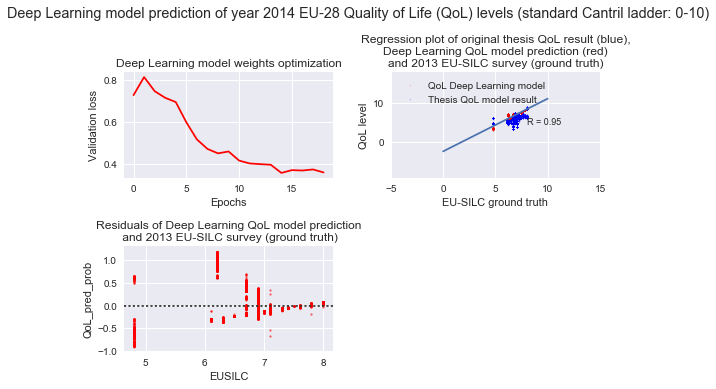

In [143]:
fig = plt.figure()
fig.suptitle('Deep Learning model prediction of year 2014 EU-28 Quality of Life (QoL) levels (standard Cantril ladder: 0-10)')

ax = plt.subplot(2,2,1)
ax.set_title('Deep Learning model weights optimization')
ax.plot(history.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')

ax = plt.subplot(2,2,2)
ax.set_title('\n\nRegression plot of original thesis QoL result (blue),\n\
Deep Learning QoL model prediction (red)\n\
and 2013 EU-SILC survey (ground truth)')
ax.plot(x, y, 'red', marker='.', linestyle='none', ms=3, alpha=.2, label='QoL Deep Learning model')
ax.plot(x, y_thesis, 'blue', marker='.', linestyle='none', ms=3, alpha=.2, label='Thesis QoL model result')
ax.margins(0.5)
plt.annotate('R = ' + str(round(pearson_R, 2)), xy=(np.max(x), np.max(y) - 4), fontsize=9)
plt.xlabel('EU-SILC ground truth')
plt.ylabel('QoL level')
ax.legend(loc='upper left')
# Perform a linear regression, to find the slope a and intercept b, using np.polyfit() of order 1: a, b
a, b = np.polyfit(x, y, 1)
# Make theoretical line to plot using the found a, b
X = np.array([0, 10])
y_pred = a * X + b
# Add regression line to the plot
ax.plot(X, y_pred)

ax = plt.subplot(2,2,3)
# Plot a linear regression
ax.set_title('Residuals of Deep Learning QoL model prediction\n and 2013 EU-SILC survey (ground truth)')
sns.residplot(x='EUSILC', y='QoL_pred_prob', data=df_combined, color='red',
              scatter_kws={"s": 5, "alpha": .6})

# Draw the plot
plt.tight_layout()
plt.show()